In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from IPython.display import Image
import os
!ls ../input/
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/metric-plot/download (1).png
competitive-data-science-predict-future-sales  metric-plot


# **The goal of this notebook was to do something different from the others and to show my abilities to approach a problem and my skills in Python.**

In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
import joblib

from optuna.samplers import TPESampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

In [3]:
sales_train = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
item_categories = pd.read_csv('../input/competitive-data-science-predict-future-sales/item_categories.csv')
test = pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')


# **Check if there is NaN values**

In [4]:
number_errors=sales_train.isna().sum()

# **Creating the Dataset**
   **The goal of the competition is to predict the future sales for November 2015. At a first glance, we will predict this for October 2015 in order to find the best model possible. We have to create our Dataset. Firstly, we need to compute the sum for each month for each product and shop. We need to be careful and to compute, therefore, the mean of the item price for each month. Also, we have to clip the value between 0 and 20 because the true target values are between those values (constraint from the competition rules). In order to create a model based on the results of the prediction of October 2015, I choose to add for each month the couple (shop_id, item_id) if it does not exist. Moreover, I have to fill the columns "item_name" and "item_price". For "item_name", I will use Label Encoder because there is to many items and OneHotEncoder is too heavy for my computer in this case. For "item_price", I will use SimpleImputer (mean) and adding a column describing that we have filled the NaN values.**

In [56]:
X = sales_train.groupby(["date_block_num","shop_id","item_id"]).agg({"item_price":"mean","item_cnt_day":"sum"})
X.reset_index(inplace = True)
X.rename(columns = {"item_cnt_day":"item_cnt_month"}, inplace = True)
X = X.merge(items, how = "left", on = ["item_id"])
list_month = list(X["date_block_num"].unique())
X.set_index("date_block_num", inplace = True)
X["item_cnt_month"] = X["item_cnt_month"].clip(0,20)
X_test = X.loc[33,:]
Y_test = X_test.loc[:,"item_cnt_month"]
X_test.drop("item_cnt_month",axis = 1, inplace = True)
X_oct_2015_concat = X.loc[33,["shop_id", "item_id", "item_name", "item_category_id"]]
X_oct_2015_concat.reset_index(inplace = True)
X.reset_index(inplace = True)
X_new = pd.DataFrame()
for i in list_month:
    X_new = pd.concat([X_new,X[(X["date_block_num"] == int(i))]], axis = 0) #I create the missing couples shop_id, item_id of October 2015 for each month 
    X_oct_2015_concat["date_block_num"].replace(33, int(i), inplace = True) 
    X_new = pd.concat([X_new,X_oct_2015_concat], axis = 0)
X_new.drop_duplicates(subset = ["shop_id","item_id","date_block_num"], inplace = True)
X_new.isna().sum()

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
         date_block_num  shop_id  item_id  item_price  item_cnt_month  \
0                     0        0       32       221.0             6.0   
1                     0        0       33       347.0             3.0   
2                     0        0       35       247.0             1.0   
3                     0        0       43       221.0             1.0   
4                     0        0       51       128.5             2.0   
...                 ...      ...      ...         ...             ...   
1609119              33       59    22087       119.0             6.0   
1609120              33       59    22088       119.0             2.0   
1609121              33       59    22091       179.0             1.0   
1609122              33       59    22100       629.0             1.0   
1609123              33       59    22102      1250.0             1.0 

'\n\n'

# **Label Encoder**


In [64]:
categ_var=(X_new.dtypes=="object")
categ_var=list(categ_var[categ_var].index)
label_encoder=LabelEncoder()
for categ_col in categ_var:
    X_new[categ_col]=label_encoder.fit_transform(X_new[categ_col])
    X_test[categ_col]=label_encoder.transform(X_test[categ_col])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# **Missing Values**

In [80]:
X_new["item_cnt_month"].fillna(0, inplace = True) #on met 0 si nan pour le nombre de ventes
X_new["item_price_" + 'missed'] = X_new["item_price"].isnull()
X_test["item_price_" + 'missed'] = X_test["item_price"].isnull()
my_imputer = SimpleImputer()
X_train = pd.DataFrame(my_imputer.fit_transform(X_new))
X_train.columns = X_new.columns
X_train.set_index("date_block_num", inplace = True)
X_train.drop(labels = 33, inplace = True)
Y_train = X_train["item_cnt_month"]
X_train.drop(["item_cnt_month","item_price_missed"], axis = 1, inplace = True)
X_test.drop("item_price_missed", axis = 1, inplace = True)
print(Y_train, Y_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


date_block_num
0.0     6.0
0.0     3.0
0.0     1.0
0.0     1.0
0.0     2.0
       ... 
32.0    3.0
32.0    1.0
32.0    3.0
32.0    1.0
32.0    1.0
Name: item_cnt_month, Length: 1607139, dtype: float64 date_block_num
33    1.0
33    3.0
33    1.0
33    1.0
33    1.0
     ... 
33    6.0
33    2.0
33    1.0
33    1.0
33    1.0
Name: item_cnt_month, Length: 31531, dtype: float64


# **Modelling**
**I will use Optuna in order to find the best parameters for my model. I choose LightGBM because it is faster than XGBoost and the accuracy are nearly the same.**

In [81]:
def objective(trial):
    bagging_freq =  trial.suggest_int('bagging_freq',1,10),
    min_data_in_leaf =  trial.suggest_int('min_data_in_leaf',50,100),
    max_depth = trial.suggest_int('max_depth',1,50),
    learning_rate = trial.suggest_loguniform('learning_rate',0.001,0.1),
    num_leaves = trial.suggest_int('num_leaves',70,200),
    num_threads = trial.suggest_int('num_threads',1,50),
    min_sum_hessian_in_leaf = trial.suggest_int('min_sum_hessian_in_leaf',1,50),
    lambda_l1=trial.suggest_uniform('lambda_l1',0,5)
    
    model = lgb.LGBMRegressor(
        verbosity = 1,
        bagging_seed = 0,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'auc',
        lambda_l1=lambda_l1,
        bagging_freq = bagging_freq ,
        min_data_in_leaf = min_data_in_leaf,
        max_depth = max_depth,
        learning_rate = learning_rate,
        num_leaves = num_leaves,
        num_threads = num_threads,
        min_sum_hessian_in_leaf = min_sum_hessian_in_leaf)

    model.fit(X_train,Y_train)
    pred=model.predict(X_test)
    score_mae=mean_squared_error(Y_test, pred)
    return np.sqrt(score_mae)

sampler = TPESampler(seed = 10)
study = optuna.create_study(direction = "minimize", sampler = sampler)
study.optimize(objective, n_trials = 100)

[I 2021-02-16 11:56:57,269] Finished trial#0 with value: 2.2846454471332995 with parameters: {'bagging_freq': 10, 'min_data_in_leaf': 86, 'max_depth': 16, 'learning_rate': 0.018505314477536703, 'num_leaves': 193, 'num_threads': 29, 'min_sum_hessian_in_leaf': 26, 'lambda_l1': 2.9166086846886814}. Best is trial#0 with value: 2.2846454471332995.
[I 2021-02-16 11:57:35,658] Finished trial#1 with value: 2.4625626784187102 with parameters: {'bagging_freq': 2, 'min_data_in_leaf': 58, 'max_depth': 10, 'learning_rate': 0.0021788216053884022, 'num_leaves': 110, 'num_threads': 37, 'min_sum_hessian_in_leaf': 17, 'lambda_l1': 4.083009176103333}. Best is trial#0 with value: 2.2846454471332995.
[I 2021-02-16 11:57:48,458] Finished trial#2 with value: 2.449587854898294 with parameters: {'bagging_freq': 7, 'min_data_in_leaf': 74, 'max_depth': 44, 'learning_rate': 0.0024902538836231187, 'num_leaves': 103, 'num_threads': 9, 'min_sum_hessian_in_leaf': 37, 'lambda_l1': 1.4593803408531658}. Best is trial#0 

[I 2021-02-16 12:06:56,452] Finished trial#23 with value: 2.152174738223574 with parameters: {'bagging_freq': 2, 'min_data_in_leaf': 55, 'max_depth': 43, 'learning_rate': 0.09995262243735592, 'num_leaves': 120, 'num_threads': 13, 'min_sum_hessian_in_leaf': 13, 'lambda_l1': 0.93120998428754}. Best is trial#23 with value: 2.152174738223574.
[I 2021-02-16 12:07:13,317] Finished trial#24 with value: 2.2182995952359823 with parameters: {'bagging_freq': 2, 'min_data_in_leaf': 61, 'max_depth': 43, 'learning_rate': 0.05485669689378104, 'num_leaves': 120, 'num_threads': 17, 'min_sum_hessian_in_leaf': 5, 'lambda_l1': 0.8151067911036041}. Best is trial#23 with value: 2.152174738223574.
[I 2021-02-16 12:07:26,036] Finished trial#25 with value: 2.2353625765707466 with parameters: {'bagging_freq': 1, 'min_data_in_leaf': 67, 'max_depth': 29, 'learning_rate': 0.03872485980965592, 'num_leaves': 140, 'num_threads': 12, 'min_sum_hessian_in_leaf': 17, 'lambda_l1': 2.264477027634432}. Best is trial#23 with

[I 2021-02-16 12:14:01,252] Finished trial#46 with value: 2.2364876245358487 with parameters: {'bagging_freq': 3, 'min_data_in_leaf': 70, 'max_depth': 38, 'learning_rate': 0.03758340530640323, 'num_leaves': 138, 'num_threads': 11, 'min_sum_hessian_in_leaf': 19, 'lambda_l1': 0.3007422048696764}. Best is trial#23 with value: 2.152174738223574.
[I 2021-02-16 12:14:15,429] Finished trial#47 with value: 2.220156481725608 with parameters: {'bagging_freq': 6, 'min_data_in_leaf': 67, 'max_depth': 32, 'learning_rate': 0.05200929135260027, 'num_leaves': 107, 'num_threads': 15, 'min_sum_hessian_in_leaf': 29, 'lambda_l1': 0.9739896571334453}. Best is trial#23 with value: 2.152174738223574.
[I 2021-02-16 12:14:45,593] Finished trial#48 with value: 2.177956039984146 with parameters: {'bagging_freq': 4, 'min_data_in_leaf': 81, 'max_depth': 26, 'learning_rate': 0.06443528085858997, 'num_leaves': 145, 'num_threads': 31, 'min_sum_hessian_in_leaf': 36, 'lambda_l1': 0.003940526139398437}. Best is trial#23

[I 2021-02-16 12:21:50,475] Finished trial#69 with value: 2.1789367510663697 with parameters: {'bagging_freq': 2, 'min_data_in_leaf': 66, 'max_depth': 47, 'learning_rate': 0.05985393336674042, 'num_leaves': 136, 'num_threads': 11, 'min_sum_hessian_in_leaf': 13, 'lambda_l1': 0.0958095119545383}. Best is trial#23 with value: 2.152174738223574.
[I 2021-02-16 12:22:02,658] Finished trial#70 with value: 2.2994836965480125 with parameters: {'bagging_freq': 3, 'min_data_in_leaf': 70, 'max_depth': 10, 'learning_rate': 0.024770589036364893, 'num_leaves': 124, 'num_threads': 9, 'min_sum_hessian_in_leaf': 12, 'lambda_l1': 0.39961062565294003}. Best is trial#23 with value: 2.152174738223574.
[I 2021-02-16 12:22:14,291] Finished trial#71 with value: 2.171384017302796 with parameters: {'bagging_freq': 3, 'min_data_in_leaf': 72, 'max_depth': 44, 'learning_rate': 0.08881464423695355, 'num_leaves': 113, 'num_threads': 12, 'min_sum_hessian_in_leaf': 14, 'lambda_l1': 0.38933618565421757}. Best is trial#2

[I 2021-02-16 12:26:55,524] Finished trial#92 with value: 2.1739466179610565 with parameters: {'bagging_freq': 1, 'min_data_in_leaf': 72, 'max_depth': 47, 'learning_rate': 0.07845447744964146, 'num_leaves': 140, 'num_threads': 7, 'min_sum_hessian_in_leaf': 33, 'lambda_l1': 0.5774246858735356}. Best is trial#83 with value: 2.152074719246693.
[I 2021-02-16 12:27:07,707] Finished trial#93 with value: 2.1606057585082263 with parameters: {'bagging_freq': 2, 'min_data_in_leaf': 70, 'max_depth': 45, 'learning_rate': 0.09964560407767219, 'num_leaves': 126, 'num_threads': 1, 'min_sum_hessian_in_leaf': 25, 'lambda_l1': 0.035089843253965636}. Best is trial#83 with value: 2.152074719246693.
[I 2021-02-16 12:27:19,415] Finished trial#94 with value: 2.174530916673995 with parameters: {'bagging_freq': 3, 'min_data_in_leaf': 74, 'max_depth': 43, 'learning_rate': 0.09355680250853675, 'num_leaves': 105, 'num_threads': 1, 'min_sum_hessian_in_leaf': 25, 'lambda_l1': 0.10370627779125689}. Best is trial#83 

In [83]:
joblib.dump(study.best_params, "new.joblib")
best_params=joblib.load('new.joblib')

# **Train the model with the best parameters**

[1]	training's l2: 6.33124	valid_1's l2: 6.21841
[2]	training's l2: 6.10351	valid_1's l2: 6.04273
[3]	training's l2: 5.91573	valid_1's l2: 5.91737
[4]	training's l2: 5.75495	valid_1's l2: 5.79819
[5]	training's l2: 5.62258	valid_1's l2: 5.71435
[6]	training's l2: 5.50813	valid_1's l2: 5.65196
[7]	training's l2: 5.41356	valid_1's l2: 5.62146
[8]	training's l2: 5.32927	valid_1's l2: 5.57206
[9]	training's l2: 5.2542	valid_1's l2: 5.56727
[10]	training's l2: 5.19005	valid_1's l2: 5.52797
[11]	training's l2: 5.1278	valid_1's l2: 5.50485
[12]	training's l2: 5.07879	valid_1's l2: 5.46756
[13]	training's l2: 5.03519	valid_1's l2: 5.44334
[14]	training's l2: 4.99289	valid_1's l2: 5.43349
[15]	training's l2: 4.95549	valid_1's l2: 5.39703
[16]	training's l2: 4.91151	valid_1's l2: 5.40333
[17]	training's l2: 4.8814	valid_1's l2: 5.37562
[18]	training's l2: 4.85536	valid_1's l2: 5.35336
[19]	training's l2: 4.8185	valid_1's l2: 5.34666
[20]	training's l2: 4.79548	valid_1's l2: 5.27441
[21]	training

[164]	training's l2: 3.89485	valid_1's l2: 4.60369
[165]	training's l2: 3.89302	valid_1's l2: 4.60528
[166]	training's l2: 3.89169	valid_1's l2: 4.60702
[167]	training's l2: 3.88914	valid_1's l2: 4.60629
[168]	training's l2: 3.88714	valid_1's l2: 4.60677
[169]	training's l2: 3.88536	valid_1's l2: 4.60914
[170]	training's l2: 3.88388	valid_1's l2: 4.60951
[171]	training's l2: 3.8798	valid_1's l2: 4.60414
[172]	training's l2: 3.87854	valid_1's l2: 4.60665
[173]	training's l2: 3.87773	valid_1's l2: 4.60652
[174]	training's l2: 3.87457	valid_1's l2: 4.60574
[175]	training's l2: 3.87243	valid_1's l2: 4.60442
[176]	training's l2: 3.87088	valid_1's l2: 4.60867
[177]	training's l2: 3.86847	valid_1's l2: 4.6093
[178]	training's l2: 3.86671	valid_1's l2: 4.6112
[179]	training's l2: 3.86575	valid_1's l2: 4.61153
[180]	training's l2: 3.86441	valid_1's l2: 4.61373
[181]	training's l2: 3.86298	valid_1's l2: 4.61362
[182]	training's l2: 3.86187	valid_1's l2: 4.61339
[183]	training's l2: 3.86062	valid

[325]	training's l2: 3.69103	valid_1's l2: 4.62337
[326]	training's l2: 3.69005	valid_1's l2: 4.62274
[327]	training's l2: 3.68973	valid_1's l2: 4.62256
[328]	training's l2: 3.68888	valid_1's l2: 4.62196
[329]	training's l2: 3.68758	valid_1's l2: 4.62229
[330]	training's l2: 3.68688	valid_1's l2: 4.62356
[331]	training's l2: 3.68648	valid_1's l2: 4.62363
[332]	training's l2: 3.68542	valid_1's l2: 4.62279
[333]	training's l2: 3.6844	valid_1's l2: 4.62335
[334]	training's l2: 3.68329	valid_1's l2: 4.6238
[335]	training's l2: 3.68289	valid_1's l2: 4.62371
[336]	training's l2: 3.68214	valid_1's l2: 4.61652
[337]	training's l2: 3.68132	valid_1's l2: 4.61661
[338]	training's l2: 3.68049	valid_1's l2: 4.61641
[339]	training's l2: 3.68023	valid_1's l2: 4.61609
[340]	training's l2: 3.67959	valid_1's l2: 4.61604
[341]	training's l2: 3.67824	valid_1's l2: 4.61637
[342]	training's l2: 3.6774	valid_1's l2: 4.61556
[343]	training's l2: 3.67615	valid_1's l2: 4.61523
[344]	training's l2: 3.67553	valid

[486]	training's l2: 3.58435	valid_1's l2: 4.63683
[487]	training's l2: 3.58353	valid_1's l2: 4.63659
[488]	training's l2: 3.58277	valid_1's l2: 4.63648
[489]	training's l2: 3.58203	valid_1's l2: 4.63609
[490]	training's l2: 3.58159	valid_1's l2: 4.63597
[491]	training's l2: 3.58133	valid_1's l2: 4.63469
[492]	training's l2: 3.58102	valid_1's l2: 4.63482
[493]	training's l2: 3.5804	valid_1's l2: 4.6342
[494]	training's l2: 3.58018	valid_1's l2: 4.63508
[495]	training's l2: 3.5796	valid_1's l2: 4.63276
[496]	training's l2: 3.5787	valid_1's l2: 4.63255
[497]	training's l2: 3.57819	valid_1's l2: 4.63246
[498]	training's l2: 3.57801	valid_1's l2: 4.63439
[499]	training's l2: 3.5775	valid_1's l2: 4.63438
[500]	training's l2: 3.57697	valid_1's l2: 4.63433
[501]	training's l2: 3.57639	valid_1's l2: 4.63412
[502]	training's l2: 3.57583	valid_1's l2: 4.63415
[503]	training's l2: 3.5754	valid_1's l2: 4.63434
[504]	training's l2: 3.57497	valid_1's l2: 4.63428
[505]	training's l2: 3.57471	valid_1'

[647]	training's l2: 3.5132	valid_1's l2: 4.64651
[648]	training's l2: 3.51291	valid_1's l2: 4.64666
[649]	training's l2: 3.51268	valid_1's l2: 4.64651
[650]	training's l2: 3.5124	valid_1's l2: 4.64647
[651]	training's l2: 3.51207	valid_1's l2: 4.64614
[652]	training's l2: 3.51154	valid_1's l2: 4.64617
[653]	training's l2: 3.51134	valid_1's l2: 4.64651
[654]	training's l2: 3.51097	valid_1's l2: 4.64633
[655]	training's l2: 3.51052	valid_1's l2: 4.64631
[656]	training's l2: 3.51014	valid_1's l2: 4.64646
[657]	training's l2: 3.50987	valid_1's l2: 4.6465
[658]	training's l2: 3.5093	valid_1's l2: 4.64601
[659]	training's l2: 3.50899	valid_1's l2: 4.64607
[660]	training's l2: 3.50865	valid_1's l2: 4.64621
[661]	training's l2: 3.50844	valid_1's l2: 4.64622
[662]	training's l2: 3.50792	valid_1's l2: 4.64556
[663]	training's l2: 3.5077	valid_1's l2: 4.64552
[664]	training's l2: 3.50725	valid_1's l2: 4.64585
[665]	training's l2: 3.50687	valid_1's l2: 4.64545
[666]	training's l2: 3.50642	valid_1

[808]	training's l2: 3.46001	valid_1's l2: 4.65301
[809]	training's l2: 3.45984	valid_1's l2: 4.6527
[810]	training's l2: 3.45937	valid_1's l2: 4.65198
[811]	training's l2: 3.45924	valid_1's l2: 4.65192
[812]	training's l2: 3.45887	valid_1's l2: 4.652
[813]	training's l2: 3.45828	valid_1's l2: 4.65169
[814]	training's l2: 3.45812	valid_1's l2: 4.65266
[815]	training's l2: 3.45787	valid_1's l2: 4.64964
[816]	training's l2: 3.45768	valid_1's l2: 4.6496
[817]	training's l2: 3.45756	valid_1's l2: 4.64947
[818]	training's l2: 3.45713	valid_1's l2: 4.65002
[819]	training's l2: 3.45684	valid_1's l2: 4.64991
[820]	training's l2: 3.45652	valid_1's l2: 4.6498
[821]	training's l2: 3.45634	valid_1's l2: 4.64979
[822]	training's l2: 3.45601	valid_1's l2: 4.6498
[823]	training's l2: 3.45588	valid_1's l2: 4.64981
[824]	training's l2: 3.45572	valid_1's l2: 4.64966
[825]	training's l2: 3.45527	valid_1's l2: 4.6498
[826]	training's l2: 3.45481	valid_1's l2: 4.64883
[827]	training's l2: 3.45459	valid_1's

[969]	training's l2: 3.41952	valid_1's l2: 4.65804
[970]	training's l2: 3.41915	valid_1's l2: 4.65794
[971]	training's l2: 3.41899	valid_1's l2: 4.65775
[972]	training's l2: 3.41882	valid_1's l2: 4.65772
[973]	training's l2: 3.41849	valid_1's l2: 4.65866
[974]	training's l2: 3.41834	valid_1's l2: 4.65877
[975]	training's l2: 3.41814	valid_1's l2: 4.65847
[976]	training's l2: 3.41789	valid_1's l2: 4.65844
[977]	training's l2: 3.41758	valid_1's l2: 4.65844
[978]	training's l2: 3.41744	valid_1's l2: 4.65851
[979]	training's l2: 3.41729	valid_1's l2: 4.65853
[980]	training's l2: 3.41713	valid_1's l2: 4.65859
[981]	training's l2: 3.41688	valid_1's l2: 4.65759
[982]	training's l2: 3.41652	valid_1's l2: 4.65776
[983]	training's l2: 3.41628	valid_1's l2: 4.6576
[984]	training's l2: 3.41618	valid_1's l2: 4.6576
[985]	training's l2: 3.41605	valid_1's l2: 4.65744
[986]	training's l2: 3.41578	valid_1's l2: 4.65464
[987]	training's l2: 3.41568	valid_1's l2: 4.65466
[988]	training's l2: 3.41552	vali

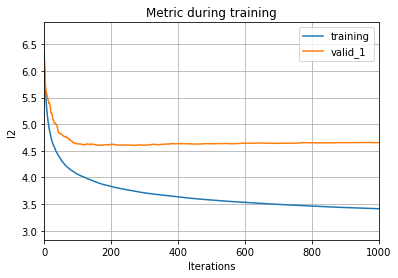

In [84]:
model = lgb.LGBMRegressor(
        verbosity = 1,
        bagging_seed = 0,
        boost_from_average = 'true',
        boost = 'gbdt',
        metric = 'mse',
        **best_params,
        n_estimators=1000)
model.fit(X_train,Y_train,eval_set=[(X_train,Y_train),(X_test,Y_test)])
pred=model.predict(X_test)
score_mae=np.sqrt(mean_squared_error(Y_test,pred))
print(score_mae)
lgb.plot_metric(model)


**We can conclude that the model is underfitting a little but the root mean squared error are quiet good = 2.1576773388831154 knowing that our model is simple. In fact, the best scores for this competition are near 1 when they try to predict for October 2015 and it was because they have done more complex model. The goal of this notebook was to do something different from the others and to show my abilities to approach a problem and my skills in Python.**

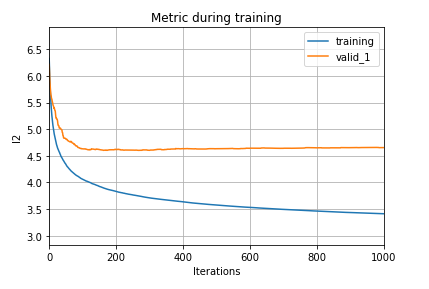

In [89]:
Image("../input/resultspredictfuturesales/Capture.PNG")